In [1]:
## This notebook will be about verifying the ability to handle the missing data cases of the MOGP

# Task
# 1 - Generate data and drop the data randomly
# 2 - Trying to modeling them jointly -> compare the performance with the cases they are modeling separately
# 3 - Increase the number of agent to see whether its could be affect to the theoretical assumption



In [2]:
## modeling the MOGP and SOGP with the vector input function (quadratic function)

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import GPy

In [3]:
np.set_printoptions(precision=4, suppress=True)

In [4]:
# define the quadractic function we want to sample

def sample_convex_quadratic(d, seed = 42, pd_shift=0.5, r_scale=0.5, mu_scale=0.25, b_scale=0.2, c_scale=0.1):
    # f(x) = (x-mu).T @ A @ (x-mu) + b.T @ x + c
    
    rng = np.random.default_rng(seed) ### using the new numpy generator function
    
    mu = rng.normal(scale=mu_scale, size=d) # random mean of features vector

    # generate random vector from a normal distribution
    R = rng.normal(scale=r_scale, size=(d, d))

    # getting the matrix A random but satisfy strictly convex (A need to be strictly PD)
    A = R.T @ R + pd_shift * np.eye(d)

    # linear part: generate the vector b
    b = rng.normal(scale=b_scale, size = d) # random vector b
    
    # additional part c
    c = rng.normal(scale=c_scale) # just random number

    return mu, A, b, c

# giving the vaue of the quadractic function given the X value
# just calculate the quad function
def evaluate_quadratic(X, mu, A, b, c):
    
    X = np.asarray(X)
    
    xm = X - mu # shifting the data -> not in the origin axis
    
    quad = np.einsum('ni,ij,nj->n', xm, A, xm)  # (x-mu)^T A (x-mu)
    
    lin = X @ b
    
    return quad + lin + c

In [5]:
## generate data and trying to modeling them separate

In [6]:
# generate the quadractic dataset
def generate_quadratic_dataset(
    n_train = 10,
    n_test = 30,
    d = 5,
    S = 3,
    seed = 42,
    noise_levels=(0.02, 0.01, 0.01),
    weight_range=(0.5, 1.2)):  # how strongly each output uses the shared quadratic latent functions

    rng = np.random.default_rng(seed)

    # sample input vectors
    # X_all = rng.normal(size=(n_train + n_test, d))
    X_all = rng.uniform(0, 0.5, size=(n_train + n_test, d))

    # sample base convex quadratic
    mu, A, b, c = sample_convex_quadratic(d, seed=seed) ## getting the params of the function
    f_all = evaluate_quadratic(X_all, mu, A, b, c)  # shape (N,) ## getting the value of the function

    # per-output mixing weights (like scaling of the based function)
    w = rng.uniform(weight_range[0], weight_range[1], size=S)

    # build outputs with Gaussian noise (each output will have different noise - independent)
    Y_list = []
    for s in range(S):
        base  = w[s] * f_all[:, None]            # (N,1)
        drift = 0
        sigma = noise_levels[s % len(noise_levels)] # getting noise level
        eps   = rng.normal(scale=sigma, size=(X_all.shape[0], 1)) # noise
        y_s   = base + drift + eps # adding noise to the output
        Y_list.append(y_s)
        
    Y_all = np.hstack(Y_list)  # getting the value for the function (noisy) - (N, S)

    # train test
    Xtr, Xte, Ytr, Yte, f_tr, f_te = train_test_split(
        X_all, Y_all, f_all, test_size=n_test, random_state=seed
    )

    # scale X only to prevent the hard optimization when the input vector value will in to differnt scale
    x_scaler = StandardScaler().fit(Xtr)
    Xtr_s = x_scaler.transform(Xtr)
    Xte_s = x_scaler.transform(Xte)

    truth = dict(mu=mu, A=A, b=b, c=c, w=w, noise_levels=noise_levels)
    return Xtr_s, Ytr, Xte_s, Yte, f_tr, f_te, truth, x_scaler

In [7]:
# define the mask for the output and taking it over then we can compare the result 
# here we consider the isotopic cases (all output sharing the same input space)

X_train, Y_train, X_test, Y_test, f_train, f_test, truth, x_scaler = generate_quadratic_dataset(
    n_train=10, n_test=20, d=5, S=3, seed=42
)

In [8]:
print("Train shapes: X =", X_train.shape, " Y =", Y_train.shape)
print("Test  shapes: X =", X_test.shape, " Y =", Y_test.shape)
print("Weights w (how much each output uses f):", truth["w"])
print("Noise levels:", truth["noise_levels"])

Train shapes: X = (10, 5)  Y = (10, 3)
Test  shapes: X = (20, 5)  Y = (20, 3)
Weights w (how much each output uses f): [1.0784 1.1273 0.5982]
Noise levels: (0.02, 0.01, 0.01)


In [9]:
# define a random mask for the input we can take one input can trying to modeling them
X_train.shape[0]

10

In [10]:
# generate a random index of the missing data:

# number of training point
num_samples = X_train.shape[0]

# percentage missing point (percent of missing)
p_missing = 0.5

# getting the number of missing point
n_missing = int(num_samples * p_missing)

# generate the random indicies
missing_indicies = (np.random.choice(num_samples, size=n_missing, replace=False))

print(missing_indicies)

[9 4 5 8 0]


In [11]:
num_output = 3
output_missing_data_index = 0 #output 1

In [12]:
#making masked data
def generate_masked(n_samples, n_outputs, missing_indicies, missing_output):
    mask_list = []
    for k in range(n_outputs):
        if k == missing_output:
            mask = np.ones(n_samples, dtype=bool)
            mask[missing_indicies] = False # False -> drop
        else:
            mask = np.ones(n_samples, dtype=bool)

        mask_list.append(mask)
    return mask_list

In [13]:
#testing generate mask data
mask_list = generate_masked(num_samples, num_output, missing_indicies, output_missing_data_index)

In [14]:
mask_list

[array([False,  True,  True,  True, False, False,  True,  True, False,
        False]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True])]

In [15]:
## getting the observed set
X_list = [X_train[mask_list[k]] for k in range(num_output)]
Y_obs = [Y_train[:, k][mask_list[k]] for k in range(num_output)] #shape

In [16]:
Y_obs[0].shape

(5,)

In [17]:
# training SOGP

def train_sogp_single_rbf_fullrun(
    X_train, Y_train,
    max_iters = 100000,         # large budget; optimizer stops early if it converges
    bound_kernel=True,         # keep things numerically stable
    noise_bounds=(1e-4, 0.1),  # bounds for Gaussian noise variance
    var_bounds=(1e-4, 1e2),    # bounds for kernel variance
    ls_bounds=(1e-4, 1e2),      # bounds for ARD lengthscales
    num_output=num_output):
    
    S = num_output
    models = []
    # store the lmls
    lmls = []
    total_time = 0.0

    for s in range(S):
        y = Y_train[s].reshape(-1, 1)

        k = GPy.kern.RBF(X_train[s].shape[1], ARD=False, name=f"rbf_s{s}") #transform the shape of the 
        
        if bound_kernel:
            k.variance.constrain_bounded(*var_bounds)
            k.lengthscale.constrain_bounded(*ls_bounds)

        m = GPy.models.GPRegression(X_train[s], y, kernel=k)
        m.Gaussian_noise.variance.constrain_bounded(*noise_bounds)

        t0 = time.perf_counter()
        m.optimize(optimizer="lbfgsb", max_iters=max_iters, messages=True)  # single full run
        total_time += (time.perf_counter() - t0)

        models.append(m)

        # adding the lmls for each models
        
        lmls.append(float(m.log_likelihood()))

        # # print model hyperparams after train
        # k = m.kern
        
        # print(f"Output {s} kernel_variance", k.variance.values)
        # print(f"Output {s} lengthscales", k.lengthscale.values)
        # print(f"Output {s} noise_variance", m.Gaussian_noise.variance.values)

    return models, np.array(lmls), total_time

In [18]:
def predictive_test_nll(y_true, mu, var, eps=1e-12):

    var = np.clip(var.reshape(-1), eps, None)
    y_true = y_true.reshape(-1); mu = mu.reshape(-1)
    return 0.5*np.mean(np.log(2*np.pi*var) + (y_true - mu)**2/var)

In [19]:
def eval_sogp(models, Xte, Yte):
    # compute the RMSE for each model as well as the nll on test output
    S = Yte.shape[1]
    rmses, nlls = [], []
    for s in range(S):
        mu, var = models[s].predict(Xte)
        rmse = np.sqrt(mean_squared_error(Yte[:, s], mu))
        rmses.append(rmse)
        nll = predictive_test_nll(Yte[:, s], mu, var)
        nlls.append(nll)
    return np.array(rmses), np.array(nlls)

In [20]:
# train & evaluate single-RBF SOGP with the missing value data
sogp_models, lmls, sogp_time = train_sogp_single_rbf_fullrun(X_list, Y_obs, max_iters=1000)

print(f"SOGP trained {len(sogp_models)} tasks in {sogp_time:.2f}s")

sogp1_rmse, sogp1_nlls = eval_sogp(sogp_models, X_test, Y_test)
print("SOGP of each GP with RBF kernels:", sogp1_rmse)
print("Mean of RMSE:", (sogp1_rmse.mean()))

reconstraining parameters rbf_s0.variance
reconstraining parameters rbf_s0.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s1.variance
reconstraining parameters rbf_s1.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s2.variance
reconstraining parameters rbf_s2.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


SOGP trained 3 tasks in 0.16s
SOGP of each GP with RBF kernels: [0.3595 0.0707 0.0465]
Mean of RMSE: 0.15889970083490632


In [21]:
X_train.shape

(10, 5)

In [22]:
## modeling them with different set of data
## running and compare the number of data points scale
## also print the prediction for the missing point of the function modeling

size_cases = [(5, 10), (10, 20), (20, 40), (40, 80), (60, 120), (100, 200), (150, 300), (200, 400)]

d, S = 5, 3 #number of the dimension input and number of output 
seeds = 123
p_missing = 0.5
output_missing_data_index = 0 #output 1

num_output = S
# percentage missing point (percent of missing)

all_results_sogp = []

for i, (ntr, nte) in enumerate(size_cases):

    X_train, Y_train, X_test, Y_test, f_train, f_test, truth, x_scaler = generate_quadratic_dataset(n_train = ntr, n_test = nte, d = d, S = S, seed = seeds + i, noise_levels=(0.02, 0.01, 0.01), weight_range=(0.5, 1.1))

    # number of training point
    num_samples = X_train.shape[0]
    
    # getting the number of missing point
    n_missing = int(num_samples * p_missing)
    
    # generate the random indicies
    missing_indicies = (np.random.choice(num_samples, size=n_missing, replace=False))
    
    # generate the mask list
    mask_list = generate_masked(num_samples, num_output, missing_indicies, output_missing_data_index)

    # getting the data
    X_list = [X_train[mask_list[k]] for k in range(num_output)]
    Y_obs = [Y_train[:, k][mask_list[k]] for k in range(num_output)]
    
    # train threee model in one times
    models, lmls, train_time = train_sogp_single_rbf_fullrun(X_list, Y_obs, max_iters=10000)

    # evaluation each output in each cases
    rmses, nlls = eval_sogp(models, X_test, Y_test)
    # rmses = eval_sogp(models, X_test, Y_test)

    # print per case
    print(f"\n=== Case {i+1}: {ntr} train / {nte} test ===")
    print("LML per output:", np.round(lmls, 4), " | mean:", np.round(lmls.mean(), 4))
    print("RMSE per output:", np.round(rmses, 4), " | mean:", np.round(rmses.mean(), 4))
    print(f"Training time: {train_time:.3f}s")

    # print model hyperparams after train
    for i in range(len(models)):
        k = models[i].kern # getting optimized params of the model i_th
        
        print(f"Output {i} kernel_variance", k.variance.values)
        print(f"Output {i} lengthscales", k.lengthscale.values)
        print(f"Output {i} noise_variance", models[i].Gaussian_noise.variance.values)

    # predict the missing point
    X_miss = X_train[missing_indicies,:] # getting the missing input point
    Y_miss_true = Y_train[missing_indicies, output_missing_data_index] # getting the true value of the missing input point

    missing_output_model = models[output_missing_data_index] ## geting the model that has the missing data
    miss_mu, miss_var = missing_output_model.predict(X_miss)

    # getting the prediction result for the missing point using the model that train only in a part of point
    miss_rmse = np.sqrt(mean_squared_error(Y_miss_true, miss_mu))
    miss_nll = predictive_test_nll(Y_miss_true, miss_mu, miss_var)

    print("RMSE prediction missing points (using appropriate model):", miss_rmse)
    print("NLL prediction missing points (using appropriate model):", miss_nll)

    all_results_sogp.append({
        "case": (ntr, nte),
        "lmls": lmls,
        "rmses": rmses, #full rmse for each output 
        "nlls": nlls, #negative log likelihood for all function
        "lml_mean": lmls.mean() if isinstance(lmls, np.ndarray) else float(lmls),
        "rmse_mean": rmses.mean(), #rmses mean in all function
        "nll_mean": nlls.mean(), # mean of nlls for each model
        "time": train_time,
        "miss_rmse": miss_rmse,
        "miss_nlls": miss_nll
    })

reconstraining parameters rbf_s0.variance
reconstraining parameters rbf_s0.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s1.variance
reconstraining parameters rbf_s1.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s2.variance
reconstraining parameters rbf_s2.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s0.variance



=== Case 1: 5 train / 10 test ===
LML per output: [-1.3571 -0.246  -0.5549]  | mean: -0.7193
RMSE per output: [0.1072 0.1117 0.1239]  | mean: 0.1143
Training time: 0.146s
Output 0 kernel_variance [0.3495]
Output 0 lengthscales [5.7602]
Output 0 noise_variance [0.0001]
Output 1 kernel_variance [0.3871]
Output 1 lengthscales [7.7508]
Output 1 noise_variance [0.0001]
Output 2 kernel_variance [0.4652]
Output 2 lengthscales [8.0655]
Output 2 noise_variance [0.0001]
RMSE prediction missing points (using appropriate model): 0.06260740487929282
NLL prediction missing points (using appropriate model): -0.5049027052398245


reconstraining parameters rbf_s0.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s1.variance
reconstraining parameters rbf_s1.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s2.variance
reconstraining parameters rbf_s2.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s0.variance
reconstraining parameters rbf_s0.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance



=== Case 2: 10 train / 20 test ===
LML per output: [-3.2482 -0.4856  2.6304]  | mean: -0.3678
RMSE per output: [0.3528 0.0906 0.0533]  | mean: 0.1656
Training time: 0.151s
Output 0 kernel_variance [1.8727]
Output 0 lengthscales [99.9933]
Output 0 noise_variance [0.0823]
Output 1 kernel_variance [18.417]
Output 1 lengthscales [21.567]
Output 1 noise_variance [0.0005]
Output 2 kernel_variance [5.0422]
Output 2 lengthscales [17.413]
Output 2 noise_variance [0.0006]
RMSE prediction missing points (using appropriate model): 0.6906920142464941
NLL prediction missing points (using appropriate model): 2.1463292813185157


reconstraining parameters rbf_s1.variance
reconstraining parameters rbf_s1.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s2.variance
reconstraining parameters rbf_s2.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s0.variance



=== Case 3: 20 train / 40 test ===
LML per output: [-9.2564 11.4916 10.8067]  | mean: 4.3473
RMSE per output: [0.2021 0.035  0.0277]  | mean: 0.0883
Training time: 0.208s
Output 0 kernel_variance [99.9999]
Output 0 lengthscales [20.6101]
Output 0 noise_variance [0.0001]
Output 1 kernel_variance [70.3124]
Output 1 lengthscales [22.1804]
Output 1 noise_variance [0.0001]
Output 2 kernel_variance [59.7504]
Output 2 lengthscales [20.9167]
Output 2 noise_variance [0.0001]
RMSE prediction missing points (using appropriate model): 0.1717749596712357
NLL prediction missing points (using appropriate model): -0.2293630544072533


reconstraining parameters rbf_s0.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s1.variance
reconstraining parameters rbf_s1.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s2.variance
reconstraining parameters rbf_s2.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s0.variance
reconstraining parameters rbf_s0.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance



=== Case 4: 40 train / 80 test ===
LML per output: [-2.5119 49.7582 42.4446]  | mean: 29.8969
RMSE per output: [0.1245 0.0201 0.015 ]  | mean: 0.0532
Training time: 0.197s
Output 0 kernel_variance [28.4549]
Output 0 lengthscales [10.856]
Output 0 noise_variance [0.0009]
Output 1 kernel_variance [100.]
Output 1 lengthscales [18.0401]
Output 1 noise_variance [0.0001]
Output 2 kernel_variance [100.]
Output 2 lengthscales [15.9718]
Output 2 noise_variance [0.0001]
RMSE prediction missing points (using appropriate model): 0.11888467945591986
NLL prediction missing points (using appropriate model): -0.954010309813164


reconstraining parameters rbf_s1.variance
reconstraining parameters rbf_s1.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s2.variance
reconstraining parameters rbf_s2.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s0.variance
reconstraining parameters rbf_s0.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance



=== Case 5: 60 train / 120 test ===
LML per output: [ 24.7039 109.6565 114.5505]  | mean: 82.9703
RMSE per output: [0.054  0.0136 0.011 ]  | mean: 0.0262
Training time: 0.232s
Output 0 kernel_variance [8.485]
Output 0 lengthscales [15.8491]
Output 0 noise_variance [0.0017]
Output 1 kernel_variance [45.5742]
Output 1 lengthscales [16.5428]
Output 1 noise_variance [0.0001]
Output 2 kernel_variance [53.8692]
Output 2 lengthscales [19.7055]
Output 2 noise_variance [0.0001]
RMSE prediction missing points (using appropriate model): 0.06453667086808221
NLL prediction missing points (using appropriate model): -1.559484355860064


reconstraining parameters rbf_s1.variance
reconstraining parameters rbf_s1.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s2.variance
reconstraining parameters rbf_s2.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s0.variance
reconstraining parameters rbf_s0.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance



=== Case 6: 100 train / 200 test ===
LML per output: [ 72.7249 234.6602 237.341 ]  | mean: 181.5754
RMSE per output: [0.0238 0.0115 0.0111]  | mean: 0.0155
Training time: 0.516s
Output 0 kernel_variance [14.125]
Output 0 lengthscales [12.7992]
Output 0 noise_variance [0.0003]
Output 1 kernel_variance [58.1409]
Output 1 lengthscales [18.4121]
Output 1 noise_variance [0.0001]
Output 2 kernel_variance [99.9996]
Output 2 lengthscales [19.7633]
Output 2 noise_variance [0.0001]
RMSE prediction missing points (using appropriate model): 0.01998895832119532
NLL prediction missing points (using appropriate model): -2.4887075686365985


reconstraining parameters rbf_s1.variance
reconstraining parameters rbf_s1.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s2.variance
reconstraining parameters rbf_s2.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s0.variance
reconstraining parameters rbf_s0.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance



=== Case 7: 150 train / 300 test ===
LML per output: [116.7071 378.9706 385.7187]  | mean: 293.7988
RMSE per output: [0.0247 0.0113 0.0117]  | mean: 0.0159
Training time: 0.622s
Output 0 kernel_variance [12.508]
Output 0 lengthscales [11.7431]
Output 0 noise_variance [0.0005]
Output 1 kernel_variance [99.9999]
Output 1 lengthscales [19.558]
Output 1 noise_variance [0.0001]
Output 2 kernel_variance [100.]
Output 2 lengthscales [19.3416]
Output 2 noise_variance [0.0001]
RMSE prediction missing points (using appropriate model): 0.023958122227517177
NLL prediction missing points (using appropriate model): -2.2857589063765835


reconstraining parameters rbf_s1.variance
reconstraining parameters rbf_s1.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


reconstraining parameters rbf_s2.variance
reconstraining parameters rbf_s2.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance



=== Case 8: 200 train / 400 test ===
LML per output: [187.0795 531.8914 551.9863]  | mean: 423.6524
RMSE per output: [0.0223 0.0111 0.0103]  | mean: 0.0146
Training time: 0.730s
Output 0 kernel_variance [2.8367]
Output 0 lengthscales [9.1319]
Output 0 noise_variance [0.0004]
Output 1 kernel_variance [99.9999]
Output 1 lengthscales [20.4725]
Output 1 noise_variance [0.0001]
Output 2 kernel_variance [30.5954]
Output 2 lengthscales [19.5605]
Output 2 noise_variance [0.0001]
RMSE prediction missing points (using appropriate model): 0.02184626254535682
NLL prediction missing points (using appropriate model): -2.390191349429206


## MOGP for missing data

In [24]:
## Modeling missing value case using the joint GP

## full rank structure
def build_lcm_kernel(d, S, Q=None, rank=None, ard=False, var_bounds=(1e-4, 100), ls_bounds=(1e-4, 100)):
    
    if rank is None:
        rank = S  # full rank as default

    parts = []
    for q in range(Q):
        rbf = GPy.kern.RBF(input_dim=d, ARD=ard, name=f"rbf{q+1}", active_dims=list(range(d)))
        rbf.variance.constrain_bounded(*var_bounds)
        rbf.lengthscale.constrain_bounded(*ls_bounds)

        B = GPy.kern.Coregionalize(input_dim=1,output_dim=S, rank=rank, name=f"B{q+1}", active_dims=[d])
        parts.append(rbf.prod(B, name=f"ICM{q+1}"))
    kern = parts[0]
    for p in parts[1:]:
        kern = kern + p
    return kern

In [25]:
## getting the neg log likelihood in testing set
def predictive_test_nll(y_true, mu, var, eps=1e-12):
    var = np.clip(var.reshape(-1), eps, None)
    y_true = y_true.reshape(-1); mu = mu.reshape(-1)
    return float(0.5*np.mean(np.log(2*np.pi*var) + (y_true - mu)**2/var))

def get_output_noise_var(model, s: int) -> float:
    """
    Return learned observation variance σ_obs,s^2 for output s
    from a GPCoregionalizedRegression model in GPy.
    """
    try:
        return float(model.likelihood.likelihoods_list[s].variance[0])
    except Exception:
        # Fallback for slightly different GPy Param access
        return float(np.asarray(model.likelihood.likelihoods_list[s].variance)[0])

## getting the MOGP values
def eval_mogp_augmented(model, X_test, Y_test, make_scatter=False):
    S, d = Y_test.shape[1], X_test.shape[1]
    rmses, nlls = [], []

    for s in range(S):
        s_idx = np.full((X_test.shape[0], 1), s, dtype=int)
        Xte_aug = np.hstack([X_test, s_idx])

        Ymd = {'output_index': s_idx}

        # mu, var = model.predict(Xte_aug, Y_metadata=Ymd) #### I change here - 
        mu, var = model.predict(Xte_aug, Y_metadata=Ymd, include_likelihood=True)
        rmses.append(np.sqrt(mean_squared_error(Y_test[:, s], mu))) # rmse for each outputs
        nlls.append(predictive_test_nll(Y_test[:, s], mu, var)) # nlls for each outputs

    return np.array(rmses), np.array(nlls)

In [26]:
def _condition_on_one(mu, Sigma, known_idx, z, obs_var=0.0):
    """
    Condition N(mu, Sigma) on f_known = z with measurement variance obs_var (R).
    Returns (mu_post_U, Sigma_post_U, U_indices).
    """
    S = mu.shape[0]
    U = [i for i in range(S) if i != known_idx]

    mu_O = float(mu[known_idx])
    mu_U = mu[U].reshape(-1)

    Sigma_OO = float(Sigma[known_idx, known_idx])
    Sigma_UO = Sigma[np.ix_(U, [known_idx])]  # (S-1, 1)
    Sigma_OU = Sigma[np.ix_([known_idx], U)]  # (1, S-1)
    Sigma_UU = Sigma[np.ix_(U, U)]           # (S-1, S-1)

    gain = Sigma_UO / (Sigma_OO + obs_var)   # <-- add R here
    mu_post_U = mu_U + (gain * (z - mu_O)).reshape(-1)
    Sigma_post_U = Sigma_UU - gain @ Sigma_OU
    return mu_post_U, Sigma_post_U, U


def eval_mogp_with_test_condition(
    model, X_test, Y_test,
    known_output_idx: int,
    obs_var_at_test: float
):
    """
    Compare baseline vs conditioning, fairly, on outputs != known_output_idx.
    Returns (base, cond, details).
    - base['rmse'/'nll']: arrays over remaining outputs
    - cond['rmse'/'nll']: arrays over remaining outputs
    """
    S = Y_test.shape[1]
    U = [i for i in range(S) if i != known_output_idx]

    # Baseline (per-output), use likelihood noise for fair NLL
    base_rmses, base_nlls = [], []
    for s in U:
        s_idx = np.full((X_test.shape[0], 1), s, dtype=int)
        Xte_aug = np.hstack([X_test, s_idx])
        Ymd = {'output_index': s_idx}
        mu_s, var_y_s = model.predict(Xte_aug, Y_metadata=Ymd, include_likelihood=True)
        base_rmses.append(np.sqrt(mean_squared_error(Y_test[:, s], mu_s)))
        base_nlls.append(predictive_test_nll(Y_test[:, s], mu_s, var_y_s))
    base = {"rmse": np.array(base_rmses), "nll": np.array(base_nlls)}

    # Conditioned: loop over test points, form joint (latent), condition with R
    updated_means = {s: [] for s in U}
    updated_vars  = {s: [] for s in U}

    for t in range(X_test.shape[0]):
        x = X_test[t:t+1, :]

        s_all = np.arange(S, dtype=int).reshape(-1, 1)
        X_aug = np.hstack([np.repeat(x, S, axis=0), s_all])
        Ymd_all = {'output_index': s_all}

        # latent joint over outputs at this test x
        mu_all, cov_full = model.predict(
            X_aug, Y_metadata=Ymd_all,
            include_likelihood=False, full_cov=True
        )
        mu_all   = mu_all.reshape(-1)               # (S,)
        cov_full = np.asarray(cov_full).reshape(S, S)

        # known (noisy) test label for the chosen output
        z = float(Y_test[t, known_output_idx])

        mu_post_U, Sigma_post_U, U_order = _condition_on_one(
            mu_all, cov_full, known_output_idx, z, obs_var=obs_var_at_test
        )

        for i, s in enumerate(U_order):
            updated_means[s].append(mu_post_U[i])
            updated_vars[s].append(Sigma_post_U[i, i])

    # Score conditioned (add each output's observation noise for NLL)
    cond_rmses, cond_nlls = [], []
    for s in U:
        mu_s = np.asarray(updated_means[s]).reshape(-1, 1)
        var_latent = np.maximum(np.asarray(updated_vars[s]).reshape(-1, 1), 1e-12)
        var_y = var_latent + get_output_noise_var(model, s)  # fair NLL
        y_s = Y_test[:, [s]]
        cond_rmses.append(np.sqrt(mean_squared_error(y_s, mu_s)))
        cond_nlls.append(predictive_test_nll(y_s, mu_s, var_y))
    cond = {"rmse": np.array(cond_rmses), "nll": np.array(cond_nlls)}
    details = {"updated_means": updated_means, "updated_vars": updated_vars, "U": U}
    return base, cond, details

In [27]:
# [X_list[i] for i in range(3)]

In [28]:
def train_mogp_lcm(
    X_train, Y_train,
    Q=None, rank=None, ard=False,
    max_iters=10000,
    var_bounds=(1e-4, 1e2),
    ls_bounds=(1e-4, 1e2),
    noise_bounds=(1e-4, 0.1)
):

    S, d = len(X_train), X_train[0].shape[1]

    # pack lists as GPy expects
    # X_list = [X_train[i] for i in range(S)] # replicate the data
    # # X_list = X_train
    # # Y_list = [Y_train[:, [s]] for s in range(S)] # geeting the training output data for each output stacking
    # Y_list = [Y_train[s].reshape(-1, 1) for s in range(S)]

    X_list = [np.asarray(Xi, dtype=float) for Xi in X_train]                    # (N_k, d)
    Y_list = [np.asarray(Yi, dtype=float).reshape(-1, 1) for Yi in Y_train]     # (N_k, 1)

    # build the kernel for LCM model/ full rank SLFM
    kern = build_lcm_kernel(d, S, Q=Q, rank=rank, ard=ard,
                            var_bounds=var_bounds, ls_bounds=ls_bounds)

    #build model
    m = GPy.models.GPCoregionalizedRegression(X_list=X_list, Y_list=Y_list, kernel=kern)

    # noise bounds per output
    for lik in m.likelihood.likelihoods_list:
        lik.variance.constrain_bounded(*noise_bounds)

    t0 = time.perf_counter() #start time train
    
    m.optimize(optimizer="lbfgsb", max_iters=max_iters, messages=True)
    
    train_time = time.perf_counter() - t0 #end time train
    
    return m, train_time

In [29]:
def get_output_noise_var(model, s: int) -> float:
    # Gaussian likelihood variance for output s (sigma^2)
    return float(model.likelihood.likelihoods_list[s].variance[0])


In [30]:
# Define your size cases (same as SOGP)
size_cases = [(5, 10), (10, 20), (20, 40), (40, 80), (60, 120), (100, 200), (150, 300), (200, 400)]

# set model params option
Q = 3            # number of latent components in LCM
rank = 3      # full rank structure (each group have R = 3, Q = 3)

ard = False      # treat all the features with equal affect to the length scale
max_iters = 10000

# Data options (match how you generated SOGP data)
d, S = 5, 3

p_missing = 0.5
output_missing_data_index = 0 #output 1
num_output = S

all_results_mogp = []

for i, (ntr, nte) in enumerate(size_cases):
    # generate data set
    X_train, Y_train, X_test, Y_test, f_train, f_test, truth, x_scaler = generate_quadratic_dataset(n_train = ntr, n_test = nte, d = d, S = S, seed = seeds + i, noise_levels=(0.02, 0.01, 0.01), weight_range=(0.5, 1.1))

    # number of training point
    num_samples = X_train.shape[0]
    
    # getting the number of missing point
    n_missing = int(num_samples * p_missing)
    
    # generate the random indicies
    missing_indicies = (np.random.choice(num_samples, size=n_missing, replace=False))
    
    # generate the mask list
    mask_list = generate_masked(num_samples, num_output, missing_indicies, output_missing_data_index)

    # getting the data
    X_list = [X_train[mask_list[k]] for k in range(num_output)]
    Y_obs = [Y_train[:, k][mask_list[k]] for k in range(num_output)]

    # train the MOGP
    mogp, t_mogp = train_mogp_lcm(
        X_list, Y_obs, Q=Q, rank=rank, ard=ard, max_iters=max_iters
    )

    # evaluate
    rmse, nll = eval_mogp_augmented(mogp, X_test, Y_test, make_scatter=False)

    # print model hyperparams after train
    print("Model detail optimized params:\n", mogp.sum)

    print("\nLearned per-output noise variances:")
    for s, lik in enumerate(mogp.likelihood.likelihoods_list):
        try:
            val = float(lik.variance[0])
        except Exception:
            val = float(np.asarray(lik.variance)[0])
        print(f"  output {s}: {val:.6g}")

    
    # collect + print output data
    lml = float(mogp.log_likelihood())
    print(f"\n=== MOGP Case {i+1}: {ntr} train / {nte} test ===")
    print("LML (overall):", round(lml, 6))
    print("RMSE per output:", np.round(rmse, 4), " | mean:", np.round(rmse.mean(), 4))
    print("NLL  per output:", np.round(nll, 4),  " | mean:", np.round(nll.mean(), 4))
    print(f"Training time: {t_mogp:.3f}s")

    # --------------------------------------PREDICT THE MISSING POINT------------------------------------------------
    
    #prediction of missing data using the joint model
    X_miss = X_train[missing_indicies,:] # getting the missing input point

    Y_miss_true = Y_train[missing_indicies, output_missing_data_index] # getting the true value of the missing input point

    # j = output_missing_data_index
    # Ymd = {"output_index": np.full((X_miss.shape[0], 1), j, dtype=int)}
    s_idx = np.full((X_miss.shape[0], 1), output_missing_data_index, dtype=int)
    Xte_aug = np.hstack([X_miss, s_idx])
    Ymd = {'output_index': s_idx}
    
    # miss_mu_joint, miss_var_joint = mogp.predict(Xte_aug, Y_metadata=Ymd)
    
    miss_mu_joint, miss_var_y_joint = mogp.predict(Xte_aug, Y_metadata=Ymd, include_likelihood=True) ## Change here
    miss_nll_joint = predictive_test_nll(Y_miss_true, miss_mu_joint, miss_var_y_joint) 

    
    # getting the prediction result for the missing point using the model that train only in a part of point
    miss_rmse_joint = np.sqrt(mean_squared_error(Y_miss_true, miss_mu_joint))
    ##
    # miss_nll_joint = predictive_test_nll(Y_miss_true, miss_mu_joint, miss_var_joint) ### I change here

    print("RMSE prediction missing points (joint GP model):", miss_rmse_joint)
    print("NLL prediction missing points (joint GP model):", miss_nll_joint)
    
    # ----------------------------------------IMPROVE PREDICTION USING THE CORRECT INPUT------------------------------
    # known_output_idx = 1
    known_output_idx = 0
    
    R_known = get_output_noise_var(mogp, known_output_idx)  # learned noise for the known output

    base, cond, details = eval_mogp_with_test_condition(
        mogp, X_test, Y_test,
        known_output_idx=known_output_idx,
        obs_var_at_test=R_known
    )
    
    # compare only across the other outputs (exclude the known one)
    print(f"[Condition on output {known_output_idx}]  Baseline RMSE (others):", np.round(base["rmse"], 4),
          "| mean:", np.round(base["rmse"].mean(), 4))
    print(f"[Condition on output {known_output_idx}]  Cond.   RMSE (others):", np.round(cond["rmse"], 4),
          "| mean:", np.round(cond["rmse"].mean(), 4))
    
    print(f"[Condition on output {known_output_idx}]  Baseline NLL (others):", np.round(base["nll"], 4),
          "| mean:", np.round(base["nll"].mean(), 4))
    print(f"[Condition on output {known_output_idx}]  Cond.   NLL (others):", np.round(cond["nll"], 4),
          "| mean:", np.round(cond["nll"].mean(), 4))

    # --------------------------

    all_results_mogp.append({
        "case": (ntr, nte),
        "rmse": rmse,
        "nll": nll,
        "rmse_mean": rmse.mean(),
        "nll_mean": nll.mean(),
        "lml": lml,
        "train_time": t_mogp,
        "missing_rmse": miss_rmse_joint,
        "missing_nll": miss_nll_joint,
        ### information when taking the conditional using the known value
        "cond_known_output": known_output_idx,
        "cond_base_rmse": base["rmse"],
        "cond_base_rmse_mean": base["rmse"].mean(),
        "cond_rmse": cond["rmse"],
        "cond_rmse_mean": cond["rmse"].mean(),
        "cond_base_nll": base["nll"],
        "cond_base_nll_mean": base["nll"].mean(),
        "cond_nll": cond["nll"],
        "cond_nll_mean": cond["nll"].mean()
    })

reconstraining parameters rbf1.variance
reconstraining parameters rbf1.lengthscale
reconstraining parameters rbf2.variance
reconstraining parameters rbf2.lengthscale
reconstraining parameters rbf3.variance
reconstraining parameters rbf3.lengthscale
reconstraining parameters gp.mixed_noise.Gaussian_noise_0.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_1.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_2.variance


reconstraining parameters rbf1.variance
reconstraining parameters rbf1.lengthscale
reconstraining parameters rbf2.variance
reconstraining parameters rbf2.lengthscale
reconstraining parameters rbf3.variance
reconstraining parameters rbf3.lengthscale
reconstraining parameters gp.mixed_noise.Gaussian_noise_0.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_1.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_2.variance


Model detail optimized params:
   sum.                   |                   value  |  constraints   |  priors
  ICM1.rbf1.variance     |                  0.0001  |  0.0001,100.0  |        
  ICM1.rbf1.lengthscale  |      3.1893427087107136  |  0.0001,100.0  |        
  ICM1.B1.W              |                  (3, 3)  |                |        
  ICM1.B1.kappa          |                    (3,)  |      +ve       |        
  ICM2.rbf2.variance     |                  0.0001  |  0.0001,100.0  |        
  ICM2.rbf2.lengthscale  |       99.99999994691818  |  0.0001,100.0  |        
  ICM2.B2.W              |                  (3, 3)  |                |        
  ICM2.B2.kappa          |                    (3,)  |      +ve       |        
  ICM3.rbf3.variance     |  0.00010000000000000002  |  0.0001,100.0  |        
  ICM3.rbf3.lengthscale  |       99.99999994653604  |  0.0001,100.0  |        
  ICM3.B3.W              |                  (3, 3)  |                |        
  ICM3.B3.kappa     

reconstraining parameters rbf1.variance
reconstraining parameters rbf1.lengthscale
reconstraining parameters rbf2.variance
reconstraining parameters rbf2.lengthscale
reconstraining parameters rbf3.variance
reconstraining parameters rbf3.lengthscale
reconstraining parameters gp.mixed_noise.Gaussian_noise_0.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_1.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_2.variance


Model detail optimized params:
   sum.                   |                   value  |  constraints   |  priors
  ICM1.rbf1.variance     |    0.006613523145231476  |  0.0001,100.0  |        
  ICM1.rbf1.lengthscale  |      14.057915501634705  |  0.0001,100.0  |        
  ICM1.B1.W              |                  (3, 3)  |                |        
  ICM1.B1.kappa          |                    (3,)  |      +ve       |        
  ICM2.rbf2.variance     |  0.00010000000009233503  |  0.0001,100.0  |        
  ICM2.rbf2.lengthscale  |       99.99998225372315  |  0.0001,100.0  |        
  ICM2.B2.W              |                  (3, 3)  |                |        
  ICM2.B2.kappa          |                    (3,)  |      +ve       |        
  ICM3.rbf3.variance     |  0.00010000000000021937  |  0.0001,100.0  |        
  ICM3.rbf3.lengthscale  |       99.99999997716832  |  0.0001,100.0  |        
  ICM3.B3.W              |                  (3, 3)  |                |        
  ICM3.B3.kappa     

reconstraining parameters rbf1.variance
reconstraining parameters rbf1.lengthscale
reconstraining parameters rbf2.variance
reconstraining parameters rbf2.lengthscale
reconstraining parameters rbf3.variance
reconstraining parameters rbf3.lengthscale
reconstraining parameters gp.mixed_noise.Gaussian_noise_0.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_1.variance


Model detail optimized params:
   sum.                   |                   value  |  constraints   |  priors
  ICM1.rbf1.variance     |  0.00010000000001493219  |  0.0001,100.0  |        
  ICM1.rbf1.lengthscale  |       99.99999999974519  |  0.0001,100.0  |        
  ICM1.B1.W              |                  (3, 3)  |                |        
  ICM1.B1.kappa          |                    (3,)  |      +ve       |        
  ICM2.rbf2.variance     |       99.93707320085723  |  0.0001,100.0  |        
  ICM2.rbf2.lengthscale  |      22.581233591599688  |  0.0001,100.0  |        
  ICM2.B2.W              |                  (3, 3)  |                |        
  ICM2.B2.kappa          |                    (3,)  |      +ve       |        
  ICM3.rbf3.variance     |  0.00010000000050082383  |  0.0001,100.0  |        
  ICM3.rbf3.lengthscale  |       99.99999992142371  |  0.0001,100.0  |        
  ICM3.B3.W              |                  (3, 3)  |                |        
  ICM3.B3.kappa     

reconstraining parameters gp.mixed_noise.Gaussian_noise_2.variance


reconstraining parameters rbf1.variance
reconstraining parameters rbf1.lengthscale
reconstraining parameters rbf2.variance
reconstraining parameters rbf2.lengthscale
reconstraining parameters rbf3.variance
reconstraining parameters rbf3.lengthscale


Model detail optimized params:
   sum.                   |                   value  |  constraints   |  priors
  ICM1.rbf1.variance     |      0.0737246860819841  |  0.0001,100.0  |        
  ICM1.rbf1.lengthscale  |       18.26215532883347  |  0.0001,100.0  |        
  ICM1.B1.W              |                  (3, 3)  |                |        
  ICM1.B1.kappa          |                    (3,)  |      +ve       |        
  ICM2.rbf2.variance     |      0.4177178419833954  |  0.0001,100.0  |        
  ICM2.rbf2.lengthscale  |       99.99999999949361  |  0.0001,100.0  |        
  ICM2.B2.W              |                  (3, 3)  |                |        
  ICM2.B2.kappa          |                    (3,)  |      +ve       |        
  ICM3.rbf3.variance     |  0.00010000000001312128  |  0.0001,100.0  |        
  ICM3.rbf3.lengthscale  |                   100.0  |  0.0001,100.0  |        
  ICM3.B3.W              |                  (3, 3)  |                |        
  ICM3.B3.kappa     

reconstraining parameters gp.mixed_noise.Gaussian_noise_0.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_1.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_2.variance


Model detail optimized params:
   sum.                   |                   value  |  constraints   |  priors
  ICM1.rbf1.variance     |       1.115548376673882  |  0.0001,100.0  |        
  ICM1.rbf1.lengthscale  |       20.92826578794924  |  0.0001,100.0  |        
  ICM1.B1.W              |                  (3, 3)  |                |        
  ICM1.B1.kappa          |                    (3,)  |      +ve       |        
  ICM2.rbf2.variance     |  0.00010009962247470995  |  0.0001,100.0  |        
  ICM2.rbf2.lengthscale  |       99.08602695765218  |  0.0001,100.0  |        
  ICM2.B2.W              |                  (3, 3)  |                |        
  ICM2.B2.kappa          |                    (3,)  |      +ve       |        
  ICM3.rbf3.variance     |   0.0001002004525433109  |  0.0001,100.0  |        
  ICM3.rbf3.lengthscale  |       99.99924929641602  |  0.0001,100.0  |        
  ICM3.B3.W              |                  (3, 3)  |                |        
  ICM3.B3.kappa     

reconstraining parameters rbf1.variance
reconstraining parameters rbf1.lengthscale
reconstraining parameters rbf2.variance
reconstraining parameters rbf2.lengthscale
reconstraining parameters rbf3.variance
reconstraining parameters rbf3.lengthscale
reconstraining parameters gp.mixed_noise.Gaussian_noise_0.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_1.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_2.variance


[Condition on output 0]  Baseline RMSE (others): [0.0113 0.0102] | mean: 0.0107
[Condition on output 0]  Cond.   RMSE (others): [0.0112 0.0104] | mean: 0.0108
[Condition on output 0]  Baseline NLL (others): [-3.0313 -3.138 ] | mean: -3.0846
[Condition on output 0]  Cond.   NLL (others): [-3.0466 -3.1327] | mean: -3.0896


Model detail optimized params:
   sum.                   |                   value  |  constraints   |  priors
  ICM1.rbf1.variance     |      0.5144544024570961  |  0.0001,100.0  |        
  ICM1.rbf1.lengthscale  |       29.67233798663433  |  0.0001,100.0  |        
  ICM1.B1.W              |                  (3, 3)  |                |        
  ICM1.B1.kappa          |                    (3,)  |      +ve       |        
  ICM2.rbf2.variance     |    0.000100416259155851  |  0.0001,100.0  |        
  ICM2.rbf2.lengthscale  |       99.99995643578691  |  0.0001,100.0  |        
  ICM2.B2.W              |                  (3, 3)  |                |        
  ICM2.B2.kappa          |                    (3,)  |      +ve       |        
  ICM3.rbf3.variance     |  0.00010532585740435022  |  0.0001,100.0  |        
  ICM3.rbf3.lengthscale  |         99.999999783722  |  0.0001,100.0  |        
  ICM3.B3.W              |                  (3, 3)  |                |        
  ICM3.B3.kappa     

reconstraining parameters rbf1.variance
reconstraining parameters rbf1.lengthscale
reconstraining parameters rbf2.variance
reconstraining parameters rbf2.lengthscale
reconstraining parameters rbf3.variance
reconstraining parameters rbf3.lengthscale
reconstraining parameters gp.mixed_noise.Gaussian_noise_0.variance


[Condition on output 0]  Baseline RMSE (others): [0.0098 0.0107] | mean: 0.0103
[Condition on output 0]  Cond.   RMSE (others): [0.0099 0.011 ] | mean: 0.0104
[Condition on output 0]  Baseline NLL (others): [-3.1928 -3.1071] | mean: -3.15
[Condition on output 0]  Cond.   NLL (others): [-3.1893 -3.0914] | mean: -3.1404


reconstraining parameters gp.mixed_noise.Gaussian_noise_1.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_2.variance


Model detail optimized params:
   sum.                   |                   value  |  constraints   |  priors
  ICM1.rbf1.variance     |  0.00010003367355382142  |  0.0001,100.0  |        
  ICM1.rbf1.lengthscale  |       99.99999999999996  |  0.0001,100.0  |        
  ICM1.B1.W              |                  (3, 3)  |                |        
  ICM1.B1.kappa          |                    (3,)  |      +ve       |        
  ICM2.rbf2.variance     |     0.10487056067723026  |  0.0001,100.0  |        
  ICM2.rbf2.lengthscale  |      27.625048440582685  |  0.0001,100.0  |        
  ICM2.B2.W              |                  (3, 3)  |                |        
  ICM2.B2.kappa          |                    (3,)  |      +ve       |        
  ICM3.rbf3.variance     |       1.210116170245312  |  0.0001,100.0  |        
  ICM3.rbf3.lengthscale  |        99.9999999999996  |  0.0001,100.0  |        
  ICM3.B3.W              |                  (3, 3)  |                |        
  ICM3.B3.kappa     

reconstraining parameters rbf1.variance
reconstraining parameters rbf1.lengthscale
reconstraining parameters rbf2.variance
reconstraining parameters rbf2.lengthscale
reconstraining parameters rbf3.variance
reconstraining parameters rbf3.lengthscale


[Condition on output 0]  Baseline RMSE (others): [0.0105 0.0106] | mean: 0.0105
[Condition on output 0]  Cond.   RMSE (others): [0.0105 0.0106] | mean: 0.0105
[Condition on output 0]  Baseline NLL (others): [-3.1397 -3.1222] | mean: -3.1309
[Condition on output 0]  Cond.   NLL (others): [-3.1411 -3.125 ] | mean: -3.133


reconstraining parameters gp.mixed_noise.Gaussian_noise_0.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_1.variance
reconstraining parameters gp.mixed_noise.Gaussian_noise_2.variance


Model detail optimized params:
   sum.                   |                   value  |  constraints   |  priors
  ICM1.rbf1.variance     |      0.2249108784259336  |  0.0001,100.0  |        
  ICM1.rbf1.lengthscale  |       99.99998736710931  |  0.0001,100.0  |        
  ICM1.B1.W              |                  (3, 3)  |                |        
  ICM1.B1.kappa          |                    (3,)  |      +ve       |        
  ICM2.rbf2.variance     |  0.00010000000000067499  |  0.0001,100.0  |        
  ICM2.rbf2.lengthscale  |       99.99999999996237  |  0.0001,100.0  |        
  ICM2.B2.W              |                  (3, 3)  |                |        
  ICM2.B2.kappa          |                    (3,)  |      +ve       |        
  ICM3.rbf3.variance     |    0.026840553871225966  |  0.0001,100.0  |        
  ICM3.rbf3.lengthscale  |      21.813709253124134  |  0.0001,100.0  |        
  ICM3.B3.W              |                  (3, 3)  |                |        
  ICM3.B3.kappa     

In [31]:
# all_results_mogp

In [32]:
import pandas as pd

rows = []
# index MOGP by case for easy lookup
mogp_by_case = {tuple(r["case"]): r for r in all_results_mogp}

for r in all_results_sogp:
    print(r)
    case = tuple(r["case"])
    m = mogp_by_case[case]  # assume both ran on the same set of cases

    rows.append({
        "case": f"{case[0]}/{case[1]}",
        # means
        "SOGP_RMSE": float(r["rmse_mean"]),
        "MOGP_RMSE": float(m["rmse_mean"]),
        "SOGP_NLL":  float(r.get("nll_mean", np.nan)),  # if you added NLLs as suggested
        "MOGP_NLL":  float(m["nll_mean"]),
        # times
        "SOGP_time": float(r["time"]),        # your stored SOGP time
        "MOGP_time": float(m["train_time"]),  # your stored MOGP time
    })

cmp_df = pd.DataFrame(rows)
cmp_df

{'case': (5, 10), 'lmls': array([-1.3571, -0.246 , -0.5549]), 'rmses': array([0.1072, 0.1117, 0.1239]), 'nlls': array([-0.69  , -0.9161, -0.6225]), 'lml_mean': -0.7193490718087195, 'rmse_mean': 0.11427859885457416, 'nll_mean': -0.7428917878619634, 'time': 0.145504299987806, 'miss_rmse': 0.06260740487929282, 'miss_nlls': -0.5049027052398245}
{'case': (10, 20), 'lmls': array([-3.2482, -0.4856,  2.6304]), 'rmses': array([0.3528, 0.0906, 0.0533]), 'nlls': array([ 0.3915, -0.8363, -1.5837]), 'lml_mean': -0.36782108325294455, 'rmse_mean': 0.16560125706517098, 'nll_mean': -0.6761840217729755, 'time': 0.1510344999987865, 'miss_rmse': 0.6906920142464941, 'miss_nlls': 2.1463292813185157}
{'case': (20, 40), 'lmls': array([-9.2564, 11.4916, 10.8067]), 'rmses': array([0.2021, 0.035 , 0.0277]), 'nlls': array([ 0.2637, -2.0517, -2.269 ]), 'lml_mean': 4.347288074167767, 'rmse_mean': 0.08827103398869084, 'nll_mean': -1.3523289023338736, 'time': 0.20798379997722805, 'miss_rmse': 0.1717749596712357, 'mis

,case,SOGP_RMSE,MOGP_RMSE,SOGP_NLL,MOGP_NLL,SOGP_time,MOGP_time
0,5/10,0.114279,0.116251,-0.742892,-0.938816,0.145504,0.505156
1,10/20,0.165601,0.082309,-0.676184,-1.192878,0.151034,2.356130
2,20/40,0.088271,0.037651,-1.352329,-2.073423,0.207984,12.090950
3,40/80,0.053190,0.016723,-2.050366,-2.634907,0.196821,30.662946
4,60/120,0.026163,0.013965,-2.507427,-2.879497,0.231927,19.198848
5,100/200,0.015464,0.013798,-2.792133,-2.895737,0.515621,44.026203
6,150/300,0.015905,0.013805,-2.792455,-2.912580,0.622221,196.669675
7,200/400,0.014565,0.013373,-2.879192,-2.949197,0.730196,285.234436


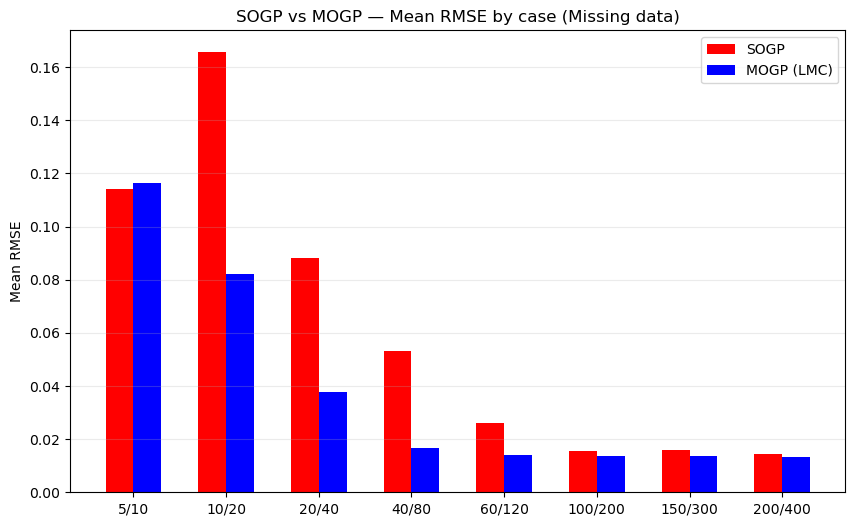

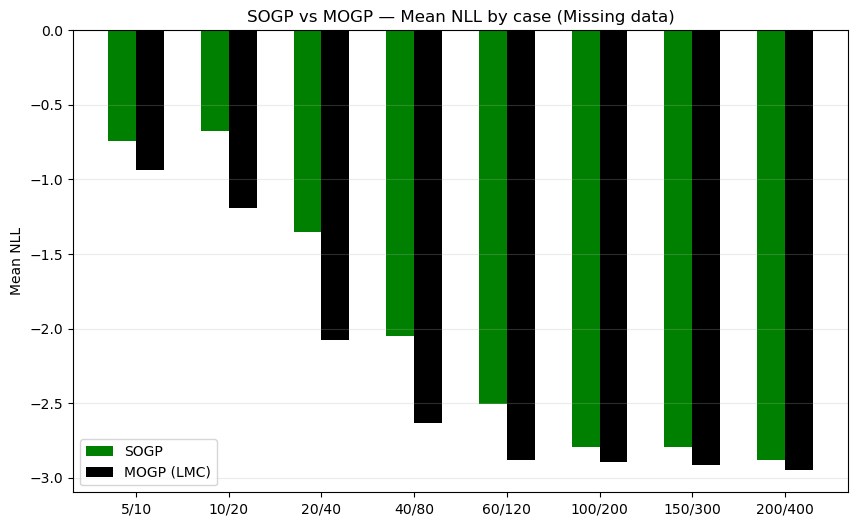

In [33]:
labels = cmp_df["case"].tolist()
x = np.arange(len(labels)); w = 0.3

# plot the rmse
plt.figure(figsize=(10, 6))
plt.bar(x - w/2, cmp_df["SOGP_RMSE"], width=w, label="SOGP", color="red")
plt.bar(x + w/2, cmp_df["MOGP_RMSE"], width=w, label="MOGP (LMC)", color="blue")
plt.xticks(x, labels)
plt.ylabel("Mean RMSE")
plt.title("SOGP vs MOGP — Mean RMSE by case (Missing data)")
plt.legend(); plt.grid(True, axis='y', alpha=0.25)
plt.show()

# plot the LLH
plt.figure(figsize=(10, 6))
plt.bar(x - w/2, cmp_df["SOGP_NLL"], width=w, label="SOGP", color="green")
plt.bar(x + w/2, cmp_df["MOGP_NLL"], width=w, label="MOGP (LMC)", color="black")
plt.xticks(x, labels)
plt.ylabel("Mean NLL")
plt.title("SOGP vs MOGP — Mean NLL by case (Missing data)")
plt.legend(); plt.grid(True, axis='y', alpha=0.25)
plt.show()

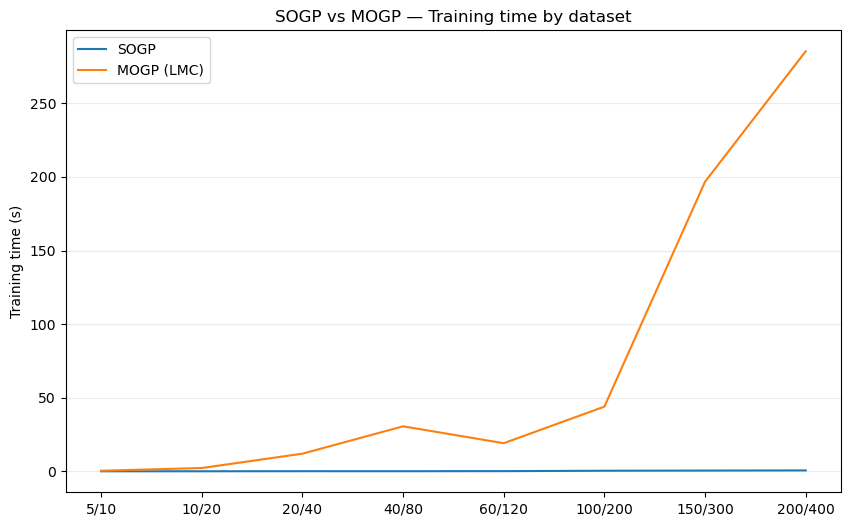

In [34]:
# training time
plt.figure(figsize=(10, 6))
plt.plot(cmp_df["SOGP_time"], label="SOGP")
plt.plot(cmp_df["MOGP_time"], label="MOGP (LMC)")
plt.xticks(x, labels)
plt.ylabel("Training time (s)")
plt.title("SOGP vs MOGP — Training time by dataset")
plt.legend(); plt.grid(True, axis='y', alpha=0.25)
plt.show()

In [35]:
# Compare the result when predict the missing points of the SOGP vs the MOGP

rows_miss_points = []

for r in all_results_sogp:
    case = tuple(r["case"])
    m = mogp_by_case[case]  # assume both ran on the same set of cases

    rows_miss_points.append({
        "case": f"{case[0]}/{case[1]}",
        # means
        "miss_rmse_so": float(r["miss_rmse"]),
        "miss_rmse_mo": float(m["missing_rmse"]),
        "miss_SOGP_NLL":  float(r.get("miss_nlls", np.nan)),  # if you added NLLs as suggested
        "miss_MOGP_NLL":  float(m["missing_nll"]),
    })

missing_pred_metrics = pd.DataFrame(rows_miss_points)
missing_pred_metrics

,case,miss_rmse_so,miss_rmse_mo,miss_SOGP_NLL,miss_MOGP_NLL
0,5/10,0.062607,0.022670,-0.504903,-1.898067
1,10/20,0.690692,0.012966,2.146329,-2.377725
2,20/40,0.171775,0.025693,-0.229363,-2.164977
3,40/80,0.118885,0.025220,-0.954010,-1.323235
4,60/120,0.064537,0.022528,-1.559484,-2.326070
5,100/200,0.019989,0.016390,-2.488708,-2.690876
6,150/300,0.023958,0.021151,-2.285759,-2.438151
7,200/400,0.021846,0.020895,-2.390191,-2.447517


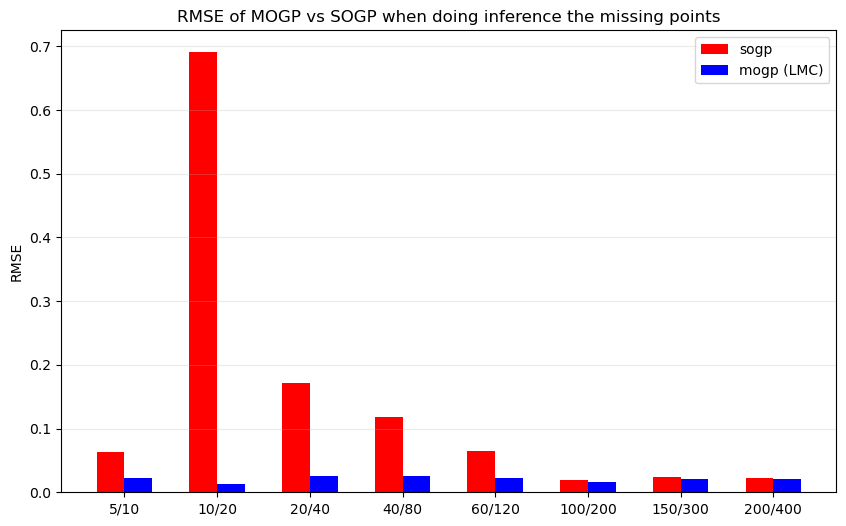

In [36]:
labels = missing_pred_metrics["case"].tolist()
x = np.arange(len(labels)); w = 0.3

# plot the rmse
plt.figure(figsize=(10, 6))
plt.bar(x - w/2, missing_pred_metrics["miss_rmse_so"], width=w, label="sogp", color="red")
plt.bar(x + w/2, missing_pred_metrics["miss_rmse_mo"], width=w, label="mogp (LMC)", color="blue")
plt.xticks(x, labels)
plt.ylabel("RMSE")
plt.title("RMSE of MOGP vs SOGP when doing inference the missing points")
plt.legend(); plt.grid(True, axis='y', alpha=0.25)
plt.show()

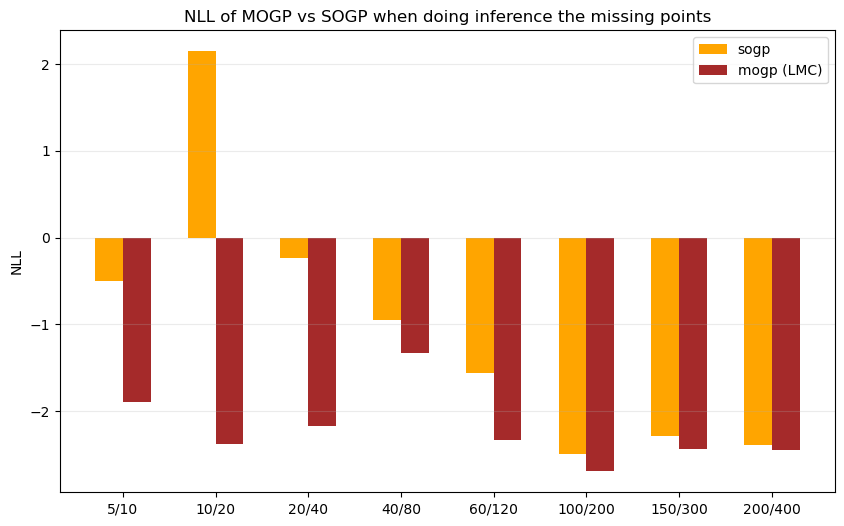

In [37]:
labels = missing_pred_metrics["case"].tolist()
x = np.arange(len(labels)); w = 0.3

# plot the rmse
plt.figure(figsize=(10, 6))
plt.bar(x - w/2, missing_pred_metrics["miss_SOGP_NLL"], width=w, label="sogp", color="orange")
plt.bar(x + w/2, missing_pred_metrics["miss_MOGP_NLL"], width=w, label="mogp (LMC)", color="brown")
plt.xticks(x, labels)
plt.ylabel("NLL")
plt.title("NLL of MOGP vs SOGP when doing inference the missing points")
plt.legend(); plt.grid(True, axis='y', alpha=0.25)
plt.show()

In [38]:
## predict the missing data given a data

## assume that we have two case:
## Case 1: Using the joint model for predict -> Calculate the MSE for the model prediction and the true value
## X* -> GP -> y* = [y1, y2, y3]
## Y  ~ 0 , Kxx + noise Kx*
## f*   0   K*x K**
# => f*|X*, X, Y  = N(f*, cov(f*))

## Case 2: Assume we have a function that asking the agent -> getting the true value for the test point -> using this value
## to estimate whether the prediction will be better than the case we do not use the true value 

## Here y* = [y*1 y*2 y*3] but the y*2 already known => how can we using this information to improve the prediction?

## We can do this way. First doing prediction like normal -> we receive the mean and covariance of the test result. Assume we have
## the true value of the k-th function -> we using the Bayes rule to update the prediction based on the true value. Here the
## true value assumed that having the noise (which include with the noise of that output as we learned from the function)


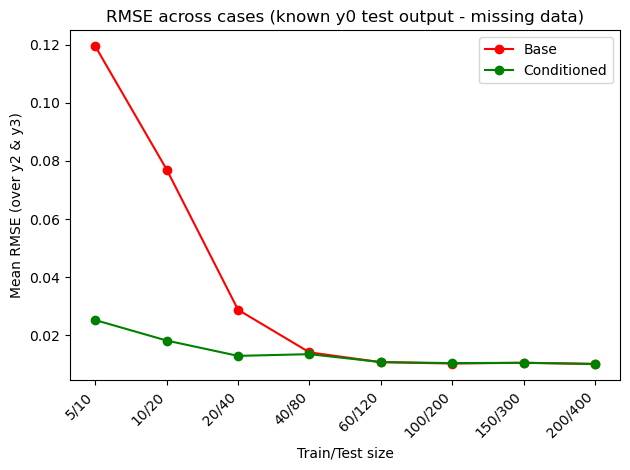

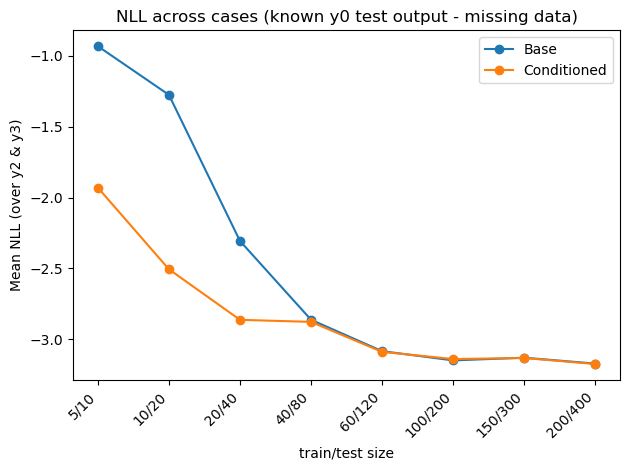

In [39]:
# Gather series
case_labels = [f"{res['case'][0]}/{res['case'][1]}" for res in all_results_mogp]
base_rmse_means = np.array([res["cond_base_rmse_mean"] for res in all_results_mogp])
cond_rmse_means = np.array([res["cond_rmse_mean"] for res in all_results_mogp])
base_nll_means  = np.array([res["cond_base_nll_mean"] for res in all_results_mogp])
cond_nll_means  = np.array([res["cond_nll_mean"] for res in all_results_mogp])

# RMSE line chart across size cases
plt.figure()
plt.plot(case_labels, base_rmse_means, marker="o", label="Base", color="red")
plt.plot(case_labels, cond_rmse_means, marker="o", label="Conditioned", color="green")
plt.xlabel("Train/Test size")
plt.ylabel("Mean RMSE (over y2 & y3)")
plt.title("RMSE across cases (known y0 test output - missing data)")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# NLL line chart across size cases
plt.figure()
plt.plot(case_labels, base_nll_means, marker="o", label="Base")
plt.plot(case_labels, cond_nll_means, marker="o", label="Conditioned")
plt.xlabel("train/test size")
plt.ylabel("Mean NLL (over y2 & y3)")
plt.title("NLL across cases (known y0 test output - missing data)")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()